In [1]:
# Character recognizer (Capitals) A to Z

In [2]:
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.cuda
import time
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from models.character_recognize import Model

In [3]:
# data source : https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format?rvi=1
PATH = 'data/A_Z Handwritten Data.csv'
df = pd.read_csv(PATH).astype('float32')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: float32(785)
memory usage: 1.1 GB


In [5]:
alphabet_map = {i: chr(ord('A') + i) for i in range(26)}
alphabet_map

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]
X = X.to_numpy()
y = y.to_numpy()
X.shape

(372450, 784)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)

# scale data
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)

X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [9]:
del df, X, y

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(335205, 784) (37245, 784) (335205,) (37245,)


In [11]:
type(y_train)

numpy.ndarray

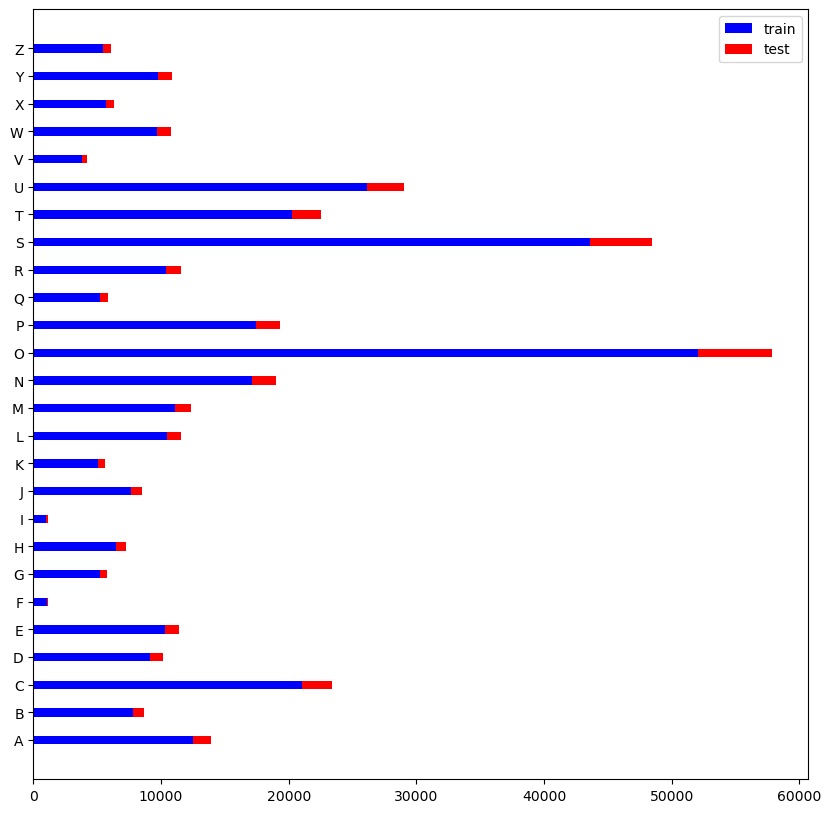

In [12]:
labels = list(alphabet_map.values())
np.count_nonzero(y_train == 9)
train_size, test_size = [], []
[(train_size.append((np.count_nonzero(y_train == i))), test_size.append((np.count_nonzero(y_test == i)))) for i in
 alphabet_map]

plt.figure(figsize=(10, 10))
plt.barh(y=labels, width=train_size, color="blue", height=0.3)
plt.barh(y=labels, width=test_size, left=train_size, color="red", height=0.3)
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
[(alphabet_map[i], np.count_nonzero(y_train == i), np.count_nonzero(y_test == i)) for i in alphabet_map]

[('A', 12482, 1387),
 ('B', 7801, 867),
 ('C', 21068, 2341),
 ('D', 9121, 1013),
 ('E', 10296, 1144),
 ('F', 1047, 116),
 ('G', 5186, 576),
 ('H', 6496, 722),
 ('I', 1008, 112),
 ('J', 7644, 849),
 ('K', 5043, 560),
 ('L', 10427, 1159),
 ('M', 11102, 1234),
 ('N', 17109, 1901),
 ('O', 52042, 5783),
 ('P', 17407, 1934),
 ('Q', 5231, 581),
 ('R', 10409, 1157),
 ('S', 43577, 4842),
 ('T', 20246, 2249),
 ('U', 26107, 2901),
 ('V', 3764, 418),
 ('W', 9706, 1078),
 ('X', 5645, 627),
 ('Y', 9773, 1086),
 ('Z', 5468, 608)]

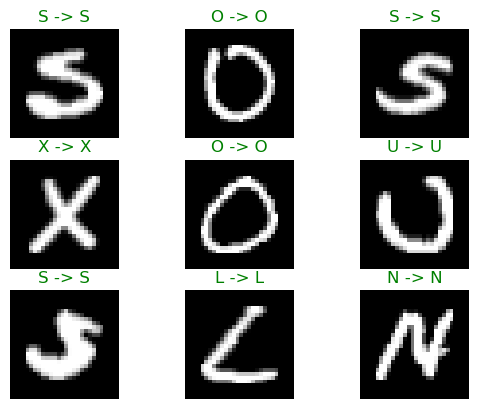

In [14]:
def show_img(X: np.ndarray, y: np.ndarray, pred: np.ndarray):
    X = X.reshape(-1, 28, 28)
    y = y.reshape(-1, 1)
    pred = pred.reshape(-1, 1)
    rows = columns = math.ceil(X.shape[0] ** 0.5)
    fig, axs = plt.subplots(rows, columns)
    for i in range(X.shape[0]):
        plt.subplot(rows, columns, i + 1)
        plt.axis('off')
        plt.imshow(X[i], cmap='grey')
        plt.title(f'{alphabet_map[y[i].item()]} -> {alphabet_map[pred[i].item()]}',
                  color=('red' if y[i].item() != pred[i].item() else 'green'))
    plt.show()


sample_index = 200000
sample_size = 9
show_img(X_train[sample_index:sample_index + sample_size], y_train[sample_index:sample_index + sample_size],
         y_train[sample_index:sample_index + sample_size])

In [15]:
class CharacterDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, device=None):
        if not device:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.X = torch.Tensor(X).type(torch.float).to(device)
        self.y = torch.Tensor(y).type(torch.uint8).to(device)
        self.length = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.length

In [16]:
train_dataset = CharacterDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10000)

test_dataset = CharacterDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=10000)

del X_train, X_test, y_train, y_test

In [18]:
epochs = 50
learning_rate = 0.001
batch_size = 10000
model = Model(4 * 4 * 16, 120, 80).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
start_time = time.time()
for i in range(epochs):
    for j, (X_batch, y_batch) in enumerate(train_loader):
        pred = model(X_batch, train=True)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (i % 5 == 0):
        print(f'epoch = {i}/{epochs}')
        with torch.no_grad():
            correct = 0
            for j, (X_batch, y_batch) in enumerate(test_loader):
                pred_test = model(X_batch)
                pred_test = torch.argmax(pred_test, dim=1)
                correct += (pred_test == y_batch).sum().item()

            acc = 100 * (correct / len(test_dataset))
            print(f'loss = {loss.item():.3f}')
            print(f'accuracy = {acc:.3f}', end=2 * '\n')

end_time = time.time()
print(f'total {end_time - start_time:.3f} seconds on {device}.')

epoch = 0/50
loss = 3.046
accuracy = 9.827
epoch = 5/50
loss = 2.562
accuracy = 71.722
epoch = 10/50
loss = 2.448
accuracy = 87.392
epoch = 15/50
loss = 2.397
accuracy = 92.606
epoch = 20/50
loss = 2.387
accuracy = 94.225
epoch = 25/50
loss = 2.377
accuracy = 94.874
epoch = 30/50
loss = 2.373
accuracy = 95.411
epoch = 35/50
loss = 2.368
accuracy = 95.704
epoch = 40/50
loss = 2.367
accuracy = 95.881
epoch = 45/50
loss = 2.369
accuracy = 96.056
total 174.556 seconds on cuda.


In [19]:
pred_test = torch.Tensor().to(device)
y_test = torch.Tensor().to(device)
for j, (X_batch, y_batch) in enumerate(test_loader):
    pred_batch = torch.argmax(model(X_batch), dim=1)
    pred_test = torch.cat((pred_test, pred_batch))
    y_test = torch.cat((y_test, y_batch))

pred_test = pred_test.to('cpu')
y_test = y_test.to('cpu')

conf_matrix = confusion_matrix(y_test, pred_test)
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for i, acc in enumerate(accuracy_per_class):
    total = conf_matrix.sum(axis=1)[i]
    right = conf_matrix.diagonal()[i]
    wrong = total - right
    print(f'Accuracy "{alphabet_map[i]}": {acc * 100:5.2f}  {total:4.0f} : {right:4.0f}|{wrong:3.0f} ')

Accuracy "A": 98.34  1387 : 1364| 23 
Accuracy "B": 96.77   867 :  839| 28 
Accuracy "C": 98.33  2341 : 2302| 39 
Accuracy "D": 94.08  1013 :  953| 60 
Accuracy "E": 96.85  1144 : 1108| 36 
Accuracy "F":  0.00   116 :    0|116 
Accuracy "G": 94.62   576 :  545| 31 
Accuracy "H": 92.52   722 :  668| 54 
Accuracy "I":  0.00   112 :    0|112 
Accuracy "J": 96.23   849 :  817| 32 
Accuracy "K": 95.18   560 :  533| 27 
Accuracy "L": 97.41  1159 : 1129| 30 
Accuracy "M": 97.97  1234 : 1209| 25 
Accuracy "N": 98.05  1901 : 1864| 37 
Accuracy "O": 99.17  5783 : 5735| 48 
Accuracy "P": 97.78  1934 : 1891| 43 
Accuracy "Q": 94.66   581 :  550| 31 
Accuracy "R": 96.37  1157 : 1115| 42 
Accuracy "S": 99.11  4842 : 4799| 43 
Accuracy "T": 99.24  2249 : 2232| 17 
Accuracy "U": 99.28  2901 : 2880| 21 
Accuracy "V":  0.00   418 :    0|418 
Accuracy "W": 96.29  1078 : 1038| 40 
Accuracy "X": 96.17   627 :  603| 24 
Accuracy "Y": 96.78  1086 : 1051| 35 
Accuracy "Z": 97.04   608 :  590| 18 


In [20]:
# saving model's stats (parameters)
FILE = 'models/character_recognizer_model.pth'
torch.save(model.state_dict(), FILE)